# Face Recognition with LBPH (using OpenCV)

## 1. Google Drive Mount & Image Datasets Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

yalefaces_path = '/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Datasets/yalefaces.zip'

zip = zipfile.ZipFile(file=yalefaces_path, mode='r')
zip.extractall('./')  # extract all file in current directory
zip.close()

- The Yale Face Database (size 6.4MB) contains 165 grayscale images in GIF format of 15 individuals. 
- There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.

In [3]:
import os

train_image_path = '/content/yalefaces/train'

# print all train image file name
all_train_image_file_name = os.listdir(train_image_path)
print(all_train_image_file_name)

['subject15.leftlight.gif', 'subject10.leftlight.gif', 'subject05.happy.gif', 'subject08.happy.gif', 'subject09.centerlight.gif', 'subject07.centerlight.gif', 'subject07.surprised.gif', 'subject08.wink.gif', 'subject09.sleepy.gif', 'subject14.centerlight.gif', 'subject14.leftlight.gif', 'subject03.sleepy.gif', 'subject11.sleepy.gif', 'subject15.normal.gif', 'subject06.rightlight.gif', 'subject01.rightlight.gif', 'subject04.glasses.gif', 'subject05.glasses.gif', 'subject12.happy.gif', 'subject03.noglasses.gif', 'subject05.sad.gif', 'subject11.rightlight.gif', 'subject12.surprised.gif', 'subject09.happy.gif', 'subject08.centerlight.gif', 'subject11.surprised.gif', 'subject01.glasses.gif', 'subject05.noglasses.gif', 'subject14.sleepy.gif', 'subject15.noglasses.gif', 'subject09.normal.gif', 'subject10.sleepy.gif', 'subject01.leftlight.gif', 'subject13.glasses.gif', 'subject05.wink.gif', 'subject14.wink.gif', 'subject11.normal.gif', 'subject12.leftlight.gif', 'subject08.noglasses.gif', 'sub

In [4]:
all_train_image_paths = [os.path.join(train_image_path, f) for f in all_train_image_file_name]
print(all_train_image_paths)

['/content/yalefaces/train/subject15.leftlight.gif', '/content/yalefaces/train/subject10.leftlight.gif', '/content/yalefaces/train/subject05.happy.gif', '/content/yalefaces/train/subject08.happy.gif', '/content/yalefaces/train/subject09.centerlight.gif', '/content/yalefaces/train/subject07.centerlight.gif', '/content/yalefaces/train/subject07.surprised.gif', '/content/yalefaces/train/subject08.wink.gif', '/content/yalefaces/train/subject09.sleepy.gif', '/content/yalefaces/train/subject14.centerlight.gif', '/content/yalefaces/train/subject14.leftlight.gif', '/content/yalefaces/train/subject03.sleepy.gif', '/content/yalefaces/train/subject11.sleepy.gif', '/content/yalefaces/train/subject15.normal.gif', '/content/yalefaces/train/subject06.rightlight.gif', '/content/yalefaces/train/subject01.rightlight.gif', '/content/yalefaces/train/subject04.glasses.gif', '/content/yalefaces/train/subject05.glasses.gif', '/content/yalefaces/train/subject12.happy.gif', '/content/yalefaces/train/subject03.

## 2. Pre-process the Images

In [5]:
import numpy as np
from PIL import Image

def fetch_preprocessed_image_data(image_paths):
    faces_of_image = []
    ids_of_image = []

    for image_path in image_paths:
        image = Image.open(image_path).convert('L')  # convert to grayscale
        # convert the image type to a numpy array type (with integer format)
        image_np = np.array(image, 'uint8')  
        image_file_name = os.path.split(image_path)[1]
        id_of_image = int(image_file_name.split('.')[0].replace('subject', ''))
        ids_of_image.append(id_of_image)
        faces_of_image.append(image_np)

    return np.array(ids_of_image), faces_of_image

In [6]:
ids_of_train_image, faces_of_train_image = fetch_preprocessed_image_data(all_train_image_paths)

In [7]:
ids_of_train_image

array([15, 10,  5,  8,  9,  7,  7,  8,  9, 14, 14,  3, 11, 15,  6,  1,  4,
        5, 12,  3,  5, 11, 12,  9,  8, 11,  1,  5, 14, 15,  9, 10,  1, 13,
        5, 14, 11, 12,  8,  1,  3, 13, 12, 13,  3,  1, 13,  3, 10, 14,  1,
       11, 14,  7, 15,  8,  7,  3, 15, 10, 13,  2,  5,  6,  2,  6, 12,  3,
        7, 13,  4,  7,  9, 10, 12,  2,  7,  4,  8, 12,  9,  6, 15, 15,  8,
       12, 10,  6,  2, 10,  3,  6,  5,  7,  2,  9, 15,  5,  8,  1,  2, 15,
       13, 14, 12, 13,  4,  1, 10,  2, 11,  1,  8,  9,  4,  7, 10,  4,  6,
       11,  6,  5,  9,  6, 14, 13, 14,  4,  3, 11,  4,  2,  2, 11,  4])

In [8]:
faces_of_train_image[0]

array([[108, 116, 117, ..., 156, 147, 167],
       [237, 248, 244, ..., 163, 152, 171],
       [236, 243, 228, ..., 158, 157, 175],
       ...,
       [231, 223, 222, ..., 130, 123, 123],
       [241, 227, 230, ..., 124, 114, 122],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

In [9]:
len(ids_of_train_image), len(faces_of_train_image)

(135, 135)

## 3. Get LBP Converted Image from the Original Image

In [10]:
from skimage.feature import local_binary_pattern

# Original image as a numpy array
original_image = faces_of_train_image[5]

# Compute LBP image with radius=3 and n_points=8*3
lbp_image = local_binary_pattern(original_image, 8*3, 3)

# Normalize the LBP image to the range [0, 255]
lbp_image = ((lbp_image - lbp_image.min()) / (lbp_image.max() - lbp_image.min())) * 255

# Convert the LBP image to integer data type
lbp_image = lbp_image.astype(np.uint8)

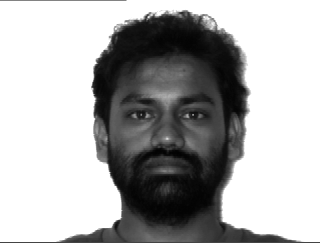

In [11]:
from google.colab.patches import cv2_imshow

cv2_imshow(original_image)

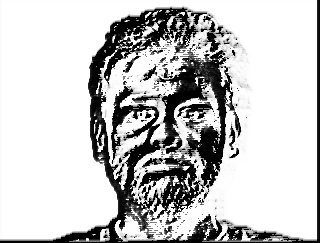

In [12]:
cv2_imshow(lbp_image)

## 4. Train the LBPH Recognizer

In [13]:
import cv2

lbph_recognizer = cv2.face.LBPHFaceRecognizer_create(radius=5, neighbors=15, grid_x=10, grid_y=10)

lbph_recognizer.train(faces_of_train_image, ids_of_train_image)  # Train the lbph recognizer

## 5. Predict with the LBPH Recognizer

In [14]:
test_image_path = '/content/yalefaces/test'

all_test_image_file_name = os.listdir(test_image_path)

all_test_image_paths = [os.path.join(test_image_path, f) for f in all_test_image_file_name]

ids_of_test_image, faces_of_test_image = fetch_preprocessed_image_data(all_test_image_paths)

In [15]:
id_pred, confidence_pred = lbph_recognizer.predict(faces_of_test_image[0])

id_pred, confidence_pred

(11, 88.48699892288407)

- The first value is the predicted target ID
- The second value means the confidence, the higher is the quality of the detections better.

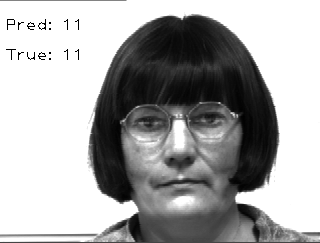

In [16]:
cv2.putText(faces_of_test_image[0], f'Pred: {str(id_pred)}', (5, 30), cv2.FONT_HERSHEY_PLAIN, 1.1, (0, 255, 0))
cv2.putText(faces_of_test_image[0], f'True: {str(ids_of_test_image[0])}', (5, 60), cv2.FONT_HERSHEY_PLAIN, 1.1, (0,255,0))

cv2_imshow(faces_of_test_image[0])

## 6. Evaluate the Performance

In [17]:
ids_pred = []

# Prediction
for face_of_test_image in faces_of_test_image:
    id_pred, _ = lbph_recognizer.predict(face_of_test_image)
    ids_pred.append(id_pred)

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(ids_of_test_image, ids_pred)

0.7